In [ ]:
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.models import load_model, Sequential
from keras.layers import Dense, Input
from keras import regularizers

%matplotlib  inline

# Load preprocesed data

In [3]:
train_data = np.load("X_train_flags.npy")
test_data = np.load("X_test_flags.npy")
print("Number of attributes:",train_data.shape[1]-1)

Number of attributes: 35


Split to test and dev sets  to train multilayer perceptron model

In [4]:
X_test_num_samples = test_data.shape[0]
dev_split = int(X_test_num_samples*0.5)
test_split = int(X_test_num_samples - dev_split)
train_num_samples = train_data.shape[0]


X_train_nn = train_data[:,:-1]
y_train_nn = train_data[:,-1:].reshape(train_num_samples, 1)
y_train_nn = np.hstack([1-y_train_nn,y_train_nn])


X_dev_nn = test_data[:dev_split,:-1]
y_dev = test_data[:dev_split,-1:].reshape(dev_split, 1) 
y_dev_nn = np.hstack([1-y_dev,y_dev])


X_test = test_data[dev_split:,:-1]
y_test = test_data[dev_split:,-1:].reshape(test_split, 1) 
y_test_nn = np.hstack([1-y_test,y_test])

# Models Tuneing

For the "sklearn" models 3 fold crossvalidation will be used to tuneing 

In [5]:
X_train = np.vstack([train_data[:,:-1], test_data[:dev_split,:-1]])
y_train = np.vstack([train_data[:,-1:], test_data[:dev_split,-1:]]).reshape(dev_split+train_num_samples,1)

Helper function for the best paramaters search regarding the sklearn used classifiers

In [ ]:
def create_df(**kwargs):
    return pd.DataFrame.from_dict(kwargs)

Tune Linear SVM, while using ANOVA-F test for feature selection

In [ ]:
pipe = Pipeline([
    ('reduce_dim',  SelectKBest(f_classif)),
    ('classify', SVC(kernel="linear"))
    ])

N_FEATURES_OPTIONS = [3, 5 ,10, 15, 25, 35]
C_OPTIONS = [0.0001,0.001,0.01,0.1,1,10,100,1000]

param_grid = [
    {
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS,
    }
            ]
grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid, scoring="roc_auc")
grid.fit(X_train, y_train.ravel())

# The best found parameters
print(grid.best_params_)

# The results for the whole search are stored in - grid.cv_results_
C_s =  []
Anova_K_best = []
for  params in grid.cv_results_['params']:
    C_s.append(params['classify__C'])
    Anova_K_best.append(params['reduce_dim__k'])
res_svm_search = create_df(C=C_s, k_best=Anova_K_best, mean_scores=grid.cv_results_['mean_test_score'],
          std_score=grid.cv_results_['std_test_score'])

Greate a dafaframe with the parametars and the test scores

In [ ]:
res_svm_search.sort_values(by=['mean_scores'], ascending=False, inplace=True)
res_svm_search

Tune Logistic Regression, while using ANOVA-F test for feature selection

In [ ]:
pipe = Pipeline([
    ('reduce_dim',  SelectKBest(f_classif)),
    ('classify', LogisticRegression())
    ])

N_FEATURES_OPTIONS = [3, 5 ,10, 15, 25, 35]
C_OPTIONS = [0.0001,0.001,0.01,0.1,1,10,100,1000]

param_grid = [
    {
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS,
    }
            ]
grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid, scoring="roc_auc")
grid.fit(X_train, y_train.ravel())


C_s =  []
Anova_K_best = []
for  params in grid.cv_results_['params']:
    C_s.append(params['classify__C'])
    Anova_K_best.append(params['reduce_dim__k'])
res_log_reg_search = create_df(C=C_s, k_best=Anova_K_best, mean_scores=grid.cv_results_['mean_test_score'],
          std_score=grid.cv_results_['std_test_score'])

res_log_reg_search.sort_values(by=['mean_scores'], ascending=False, inplace=True)
res_log_reg_search

Tune Adaboost forest

In [ ]:
DTC = DecisionTreeClassifier()

pipe = Pipeline([
    ('reduce_dim',  SelectKBest(f_classif)),
    ('classify', AdaBoostClassifier(base_estimator = DTC))
    ])

N_FEATURES_OPTIONS = [3, 5 ,10, 15, 25, 35]
LERNING_RATES = [0.2, 0.6, 1, 1.5, 2, 2.5, 3]
ESTIMETORS_NUM = [40, 50, 100, 140, 170, 220, 300, 400]
DEPTHS = [1,2,3]

param_grid = [
    {
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__n_estimators': ESTIMETORS_NUM,
        'classify__learning_rate': LERNING_RATES,
        'classify__base_estimator__max_depth': DEPTHS
    }
            ]
grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid, scoring="roc_auc")
grid.fit(X_train, y_train.ravel())

Est_num_param =  []
Lerning_rate_param = []
Anova_K_best = []
Depths = []
for  params in grid.cv_results_['params']:
    Est_num_param.append(params['classify__n_estimators'])
    Lerning_rate_param.append(params['classify__learning_rate'])
    Depths.append(params['classify__base_estimator__max_depth'])
    Anova_K_best.append(params['reduce_dim__k'])
res_boost_search = create_df(Estametors=Est_num_param, Lerning_rates=Lerning_rate_param, Depth = Depths, 
                               k_best=Anova_K_best, mean_scores=grid.cv_results_['mean_test_score'],
                               std_score=grid.cv_results_['std_test_score'])

res_boost_search.sort_values(by=['mean_scores'], ascending=False, inplace=True)
res_boost_search

Tune SVM with RBF kernel

In [ ]:
pipe = Pipeline([
    ('reduce_dim',  SelectKBest(f_classif)),
    ('classify', SVC(kernel="rbf"))
    ])

N_FEATURES_OPTIONS = [3, 5 ,10, 15, 25, 35]
C_OPTIONS =[0.0001,0.001,0.01,0.1,1,10,100,1000]
GAMMAS =[rescale/X_train.shape[1] for rescale in range(2,5)] + [1/(X_train.shape[1]*rescale) for rescale in range(2,5)]                          
GAMMAS.append("auto")

param_grid = [
    {
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS,
        'classify__gamma': GAMMAS
    }
            ]
grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid, scoring="roc_auc")
grid.fit(X_train, y_train.ravel())


C_s =  []
Anova_K_best = []
Gammas  = []
for  params in grid.cv_results_['params']:
    C_s.append(params['classify__C'])
    Anova_K_best.append(params['reduce_dim__k'])
    Gammas.append(params['classify__gamma'])
res_rbf_svm_search = create_df(C=C_s, k_best=Anova_K_best, Gamma=Gammas,
                               mean_scores=grid.cv_results_['mean_test_score'], std_score=grid.cv_results_['std_test_score'])
res_rbf_svm_search.sort_values(by=['mean_scores'], ascending=False, inplace=True)
res_rbf_svm_search

MLP without tuneing 

In [ ]:
def row_model():
    model = Sequential()
    model.add(Dense(6, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(6, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(2, activation='sigmoid'))

    return model


model = row_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
train_auc = []
test_auc = []
epochs = 40
for ep in range(epochs):
    model.fit(X_train_nn, y_train_nn, epochs=1, batch_size=32, shuffle=True,verbose=0)
    test_predictions = model.predict(X_dev_nn, batch_size=32, verbose=0)
    train_predictions = model.predict(X_train_nn, batch_size=32, verbose=0)
    roc_test = roc_auc_score(y_test_nn, test_predictions)
    roc_train = roc_auc_score(y_train_nn, train_predictions)
    train_auc.append(roc_train)
    test_auc.append(roc_test)
    
fig, ax = plt.subplots()
ax.plot(range(1,epochs+1), train_auc, "b--", label="train")
ax.plot(range(1,epochs+1), test_auc, "r--", label="test")
ax.set(xlabel='epochs', ylabel='AUC',
       title='AUC(epochs)')

ax.legend()
ax.grid()


Helper Functions for neural network tuneing

In [ ]:
def sample_learning_rate():
    x=-2*np.random.rand()-1.5
    return 10**x

def random_choice_activation():
    if np.random.rand() > 0.5:
        return "relu"
    return "tanh"

def get_score_tabel(number_models):
    params_scores = ["test_auc","train_auc", "test_acc", "train_acc","best_ep"]
    header = ["h_layer_1_nodes", "h_layer_2_nodes","h_layer_3_nodes","A1", "A2", "A3", "lerning_rate"]+params_scores
    result_df = pd.DataFrame(index=range(number_models), columns=header)
    return result_df


def fill(df,idx,vals):
    for col in range(len(vals)):
        df.iloc[idx,col] = vals[col] 
    return df

Two MLP models from which the best will be chosen

In [6]:
def model_3_layers(h_layer_1_nodes, h_layer_2_nodes, h_layer_3_nodes, A1, A2, A3, l2):
    model = Sequential()
    model.add(Dense(h_layer_1_nodes, input_dim=X_train_nn.shape[1], activation= A1,kernel_regularizer=regularizers.l2(l2)))
    model.add(Dense(h_layer_2_nodes, activation=A2 ,kernel_regularizer=regularizers.l2(l2)))
    model.add(Dense(h_layer_3_nodes, activation=A3,kernel_regularizer=regularizers.l2(l2)))
    model.add(Dense(2, activation='softmax'))
    return model

def model_2_layers(h_layer_1_nodes, h_layer_2_nodes, A1, A2,l2):
    model = Sequential()
    model.add(Dense(h_layer_1_nodes, input_dim=X_train_nn.shape[1], activation= A1,kernel_regularizer=regularizers.l2(l2)))
    model.add(Dense(h_layer_2_nodes, activation=A2 ,kernel_regularizer=regularizers.l2(l2)))
    model.add(Dense(2, activation='softmax'))
    return model

Tune multilayer perceptron with 2 hidden layers

In [ ]:
def parametar_search_2_layers():
    
    h_layer1 = range(6,30,3)
    h_layer2 = range(4,34,3)
    l2 = 0.001
    result_df = get_score_tabel(len(h_layer1)*len(h_layer2))
    i = 0
    for h_layer_1_nodes in h_layer1:
        for h_layer_2_nodes in h_layer2: 
            A1 = random_choice_activation()
            A2 = random_choice_activation()
            lerning_rate = sample_learning_rate()
            
            
            
            model = model_2_layers(h_layer_1_nodes, h_layer_2_nodes, A1, A2, l2)
            opt = Adam(lr=lerning_rate)
            model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
            
            best_test_auc = 0
            best_train_auc = 0
            best_test_acc = 0
            best_train_acc = 0
            best_ep = 0
            
            early_stoping_counter = 0
            early_stoping_delta = 0.01
            
            for ep in range(1, 40):
                model.fit(X_train_nn, y_train_nn, epochs=1, batch_size=32, shuffle=True,verbose=0)
                test_predictions = model.predict(X_dev_nn, batch_size=32, verbose=0)
                test_acc = accuracy_score(np.argmax(y_dev_nn,axis=1), np.argmax(test_predictions,axis=1))
                train_predictions = model.predict(X_train_nn, batch_size=32, verbose=0)
                train_acc = accuracy_score(np.argmax(y_train_nn,axis=1),np.argmax(train_predictions,axis=1))
                train_auc = roc_auc_score(y_train_nn, train_predictions)
                test_auc = roc_auc_score(y_dev_nn, test_predictions)
                early_stoping_counter += 1
                if test_auc>best_test_auc:
                    best_test_auc = test_auc
                    best_train_auc = train_auc
                    best_test_acc = test_acc
                    best_train_acc = train_acc
                    best_ep = ep
                    early_stoping_counter -= 1
                    if test_auc > best_test_auc+early_stoping_delta:
                        early_stoping_counter = 0
                    if early_stoping_counter == 6:
                        break
                    
            params = [h_layer_1_nodes, h_layer_2_nodes, 0,A1, A2, 0, lerning_rate]
            scores = params + [best_test_auc, best_train_auc, best_test_acc, best_train_acc,best_ep]
            print(scores)
            result_df = fill(result_df,i,scores)
            i += 1
            if i%10 == 0:
    return result_df
res_df_2 = parametar_search_2_layers()
res_df_2.sort_values(by=['test_auc'], ascending=False, inplace=True)

In [ ]:
res_df.sort_values(by=['test_auc'], ascending=False, inplace=True)

Tune multilayer perceptron with 3 hidden layers

In [ ]:
def parametar_search_3_layers():
    
    h_layer1 = range(5,30,3)
    h_layer2 = range(9,40,5)
    h_layer3 = range(6,10,1)
    l2 = 0.001
    result_df = get_score_tabel(len(h_layer1)*len(h_layer3)*len(h_layer3))
    i = 0
    for h_layer_1_nodes in h_layer1:
        for h_layer_2_nodes in h_layer2: 
            for h_layer_3_nodes in h_layer3:
                A1 = random_choice_activation()
                A2 = random_choice_activation()
                A3 = random_choice_activation()
                lerning_rate = sample_learning_rate()
            
                model = model_3_layers(h_layer_1_nodes, h_layer_2_nodes, h_layer_3_nodes, A1, A2, A3, l2)
                opt = Adam(lr=lerning_rate)
                model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
                
                best_test_auc = 0
                best_train_auc = 0
                best_test_acc = 0
                best_train_acc = 0
                best_ep = 0
                
                early_stoping_counter = 0
                early_stoping_delta = 0.01
                for ep in range(1, 30):
                    model.fit(X_train_nn, y_train_nn, epochs=1, batch_size=32, shuffle=True,verbose=0)
                    test_predictions = model.predict(X_dev_nn, batch_size=32, verbose=0)
                    test_acc = accuracy_score(np.argmax(y_dev_nn,axis=1), np.argmax(test_predictions,axis=1))
                    train_predictions = model.predict(X_train_nn, batch_size=32, verbose=0)
                    train_acc = accuracy_score(np.argmax(y_train_nn,axis=1),np.argmax(train_predictions,axis=1))
                    train_auc = roc_auc_score(y_train_nn, train_predictions)
                    test_auc = roc_auc_score(y_dev_nn, test_predictions)
                    early_stoping_counter += 1
                    if test_auc > best_test_auc:
                        best_test_auc = test_auc
                        best_train_auc = train_auc
                        best_test_acc = test_acc
                        best_train_acc = train_acc
                        best_ep = ep
                        early_stoping_counter -= 1
                        if test_auc > best_test_auc+early_stoping_delta:
                            early_stoping_counter = 0
                    if early_stoping_counter == 6:
                        break
                    
                params = [h_layer_1_nodes, h_layer_2_nodes, h_layer_3_nodes,A1, A2, A3, lerning_rate]
                scores = params + [best_test_auc, best_train_auc, best_test_acc, best_train_acc, best_ep]
                result_df = fill(result_df,i,scores)
                i += 1
                if i%10 == 0:
                    print(i)
    return result_df      
res_df = parametar_search_3_layers()
res_df.sort_values(by=['test_auc'], ascending=False, inplace=True)

Tune  regularization (l2)  of the best MLP model

In [ ]:
def l2_regularization_tuning():
    l_2 = np.geomspace(0.0001, 0.13, num=60)
    auc_results = []
    for reg in l_2:
        model = model_3_layers(14, 34, 7, "relu","relu", "tanh", reg)
        opt = Adam(lr=0.0015)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        best_test_auc = 0              
        early_stoping_counter = 0
        early_stoping_delta = 0.01
        for _ in range(1000):
            model.fit(X_train_nn, y_train_nn, epochs=1, batch_size=32, shuffle=True,verbose=0)
            test_predictions = model.predict(X_dev_nn, batch_size=32, verbose=0)
            test_auc = roc_auc_score(y_dev_nn, test_predictions)
            early_stoping_counter += 1
            if test_auc > best_test_auc:
                best_test_auc = test_auc
                early_stoping_counter -= 1
                if test_auc > best_test_auc+early_stoping_delta:
                    early_stoping_counter = 0
            if early_stoping_counter == 10:
                break
        auc_results.append(best_test_auc)
    print("Best score:",max(auc_results))
    print("Best l2:", l_2[auc_results.index(max(auc_results))])
    
    fig, ax = plt.subplots()
    ax.plot(l_2, auc_results, "bo")
    ax.plot(l_2, auc_results, "k")
    ax.set(xlabel='l2 regularization', ylabel='Test AUC',title='AUC(regularization)')
    ax.set_xscale("log")
    ax.grid()
    
l2_regularization_tuning()



Train a model and save the best weights

In [ ]:

def train_neural_network():
    model = model_3_layers(14, 34, 7, "relu","relu", "tanh", 0.0014492103248979129)
    opt = Adam(lr=0.0015)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    best_auc = 0
    train_aucs = []
    test_aucs = []
    num_epochs = 1000
    counter = 0 
    for ep in range(1, num_epochs+1):
        model.fit(X_train_nn, y_train_nn, epochs=1, batch_size=32, shuffle=True,verbose=0)
        
        test_predictions = model.predict(X_dev_nn, batch_size=32, verbose=0)
        train_predictions = model.predict(X_train_nn, batch_size=32, verbose=0)
        
        test_auc = roc_auc_score(y_dev_nn, test_predictions)
        train_auc = roc_auc_score(y_train_nn, train_predictions)
        
        train_aucs.append(train_auc)
        test_aucs.append(test_auc)
        counter += 1
        if test_auc > best_auc:
            counter = 0
            best_auc = test_auc 
            model.save_weights("weights.h5")
            best_ep = ep
        if counter == 20:
            break
    print("Best AUC:",best_auc,"  Best epoch:" ,best_ep)
    fig, ax = plt.subplots()
    ax.plot(range(1,min(num_epochs+1,best_ep+21)), train_aucs, "b--", label="train")
    ax.plot(range(1,min(num_epochs+1,best_ep+21)), test_aucs, "r--", label="valid")
    ax.set(xlabel='epochs', ylabel='AUC',
           title='AUC(epochs)')

    ax.legend()
    ax.grid()
train_neural_network()

# Models evaluation

In [ ]:
def load_best_nn_model(weights_name):
    model = model_3_layers(14, 34, 7, "relu","relu", "tanh", 0.0014492103248979129)
    model.load_weights(weights_name)
    opt = Adam(lr=0.0015)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


Logistic_Reg = LogisticRegression(C=100)
Logistic_Reg.fit(X_train, y_train)

Lin_SVM = SVC(kernel="linear", C=100)
Lin_SVM.fit(X_train, y_train)

RBF_SVM = SVC(kernel="rbf", C= 10, gamma = 0.007142857142857143)
RBF_SVM.fit(X_train, y_train)

DT_Boosted = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=140, learning_rate=0.2)
DT_Boosted.fit(X_train, y_train)

Neural_Net = load_best_nn_model("weights.h5")

Compare the diffrent models(RBF-SVM, Adaboost, Linear-SVM, Logistic Regression, MLP with best weights saved during traing, MLP for fixed iterations)

0.7611172305271441 0.7579071597167584 0.7622501966955154 0.8121951219512196 0.789110936270653


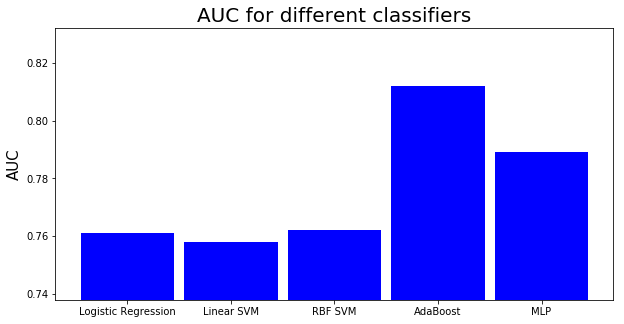

In [8]:
def evalueate_clf(Logistic_Reg, Lin_SVM, RBF_SVM, DT_Boosted, Neural_Net, X, y):
    Logistic_Reg_AUC = roc_auc_score(y, Logistic_Reg.decision_function(X))
    Lin_SVM_AUC = roc_auc_score(y, Lin_SVM.decision_function(X))
    RBF_SVM_AUC = roc_auc_score(y, RBF_SVM.decision_function(X))
    DT_Boosted_AUC = roc_auc_score(y, DT_Boosted.decision_function(X))
    Neural_Net_AUC = roc_auc_score(np.hstack([1-y,y]), Neural_Net.predict(X, batch_size=32, verbose=0))
    print(Logistic_Reg_AUC, Lin_SVM_AUC, RBF_SVM_AUC, DT_Boosted_AUC, Neural_Net_AUC)
    
    named_order = ["Logistic Regression", "Linear SVM", "RBF SVM", "AdaBoost", "MLP"]
    result = [Logistic_Reg_AUC, Lin_SVM_AUC, RBF_SVM_AUC, DT_Boosted_AUC, Neural_Net_AUC]
    ind = np.arange(len(result))  
    width = 0.9       

    fig, ax = plt.subplots(figsize=(10, 5))

    rects1 = ax.bar(ind, result, width, color='b')
    
    ax.set_ylabel('AUC',fontsize=15)
    ax.set_title('AUC for different classifiers',fontsize=20)
    ax.set_xticks(ind)
    ax.set_xticklabels((named_order))
    ax.set_ylim([min(result)-0.02,  max(result)+0.02])
evalueate_clf(Logistic_Reg, Lin_SVM, RBF_SVM, DT_Boosted, Neural_Net,  X_test, y_test)

Investigate the diversity of the classifiers. The Corss section/Union of the examples they make errors on is a suitable metric(Ansamble of them could be made if they make misatkes on diffrent examples).

[[1.         0.82003494 0.66251416 0.45005149 0.55977131]
 [0.82003494 1.         0.70028986 0.42647059 0.5156724 ]
 [0.66251416 0.70028986 1.         0.41531823 0.5527916 ]
 [0.45005149 0.42647059 0.41531823 1.         0.41675448]
 [0.55977131 0.5156724  0.5527916  0.41675448 1.        ]]


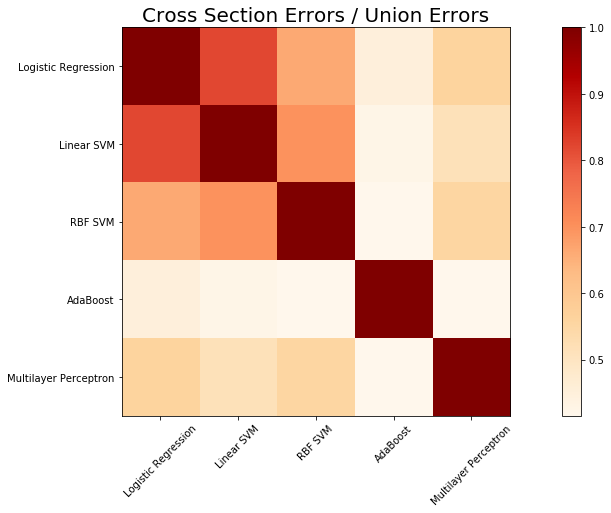

In [9]:
def compare_clf(Logistic_Reg, Lin_SVM, RBF_SVM, DT_Boosted, Neural_Net, X, y):
    
    Logistic_Reg_Pred = Logistic_Reg.predict(X).reshape(y.shape) 
    Lin_SVM_Pred = Lin_SVM.predict(X).reshape(y.shape)
    RBF_SVM_Pred = RBF_SVM.predict(X).reshape(y.shape) 
    DT_Boosted_Pred = DT_Boosted.predict(X).reshape(y.shape) 
    Neural_Net_Pred = np.argmax(Neural_Net.predict(X, batch_size=32, verbose=0), axis=1).reshape(y.shape)

    
    simalrity_matrix = np.zeros(shape = (5,5))
    named_order = ["Logistic Regression", "Linear SVM", "RBF SVM", "AdaBoost", "Multilayer Perceptron"]
    classifiers_pred = [Logistic_Reg_Pred, Lin_SVM_Pred, RBF_SVM_Pred, DT_Boosted_Pred, Neural_Net_Pred]
    
    num_samples = X.shape[0]
    
    for i in range(len(classifiers_pred)):
        for j in range(len(classifiers_pred)):
            errors_clf_i = np.not_equal(classifiers_pred[i], y)
            errors_clf_j = np.not_equal(classifiers_pred[j],y)
            crossection_errors = np.sum(np.logical_and(errors_clf_i, errors_clf_j))
            union_errors = np.sum(errors_clf_i)+np.sum(errors_clf_j)-crossection_errors
            simalrity_matrix[i,j] = crossection_errors/union_errors
    print(simalrity_matrix)
    plt.imshow(simalrity_matrix, interpolation='nearest', cmap=plt.cm.OrRd)
    plt.title('Cross Section Errors / Union Errors',fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(named_order))
    plt.xticks(tick_marks, named_order, rotation=45)
    plt.yticks(tick_marks, named_order)
    plt.tight_layout()
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18, 10)
compare_clf(Logistic_Reg, Lin_SVM, RBF_SVM, DT_Boosted, Neural_Net, np.vstack([X_train, X_test]), np.vstack([y_train, y_test]))   

Final neural net seetings just for visualisation 

In [10]:
model = Sequential()
model.add(Dense(14, input_dim=X_train_nn.shape[1], activation= "relu", kernel_regularizer=regularizers.l2(0.0014492103248979129)))
model.add(Dense(34, activation= "relu", kernel_regularizer=regularizers.l2(0.0014492103248979129)))
model.add(Dense(7, activation="tanh",kernel_regularizer=regularizers.l2(0.0014492103248979129)))
model.add(Dense(2, activation='softmax'))
opt = Adam(lr=0.0015)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 14)                504       
_________________________________________________________________
dense_6 (Dense)              (None, 34)                510       
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 245       
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 16        
Total params: 1,275
Trainable params: 1,275
Non-trainable params: 0
_________________________________________________________________
